# GEOL 593: Seismology and Earth (*and Mars*) Structure

## Lab assignment 9: InSight- Seismology on Mars

### Locating Marsquakes

On Earth, the classical problem of earthquake hypocenter location is solved using triangulation, which requires a network of seismic instruments. Based on the time it takes for waves to reach different seismic stations, an earthquake location can be determined, provided a seismic velocity model. On Mars, we only have a single seismometer, so we can not use triangulation. Instead, we need to make use of knowledge on the *polarization* of seismic waves, along with apriori models of the subsurface velocities in the crust and mantle.

In part 1 of this lab, you will be locating the event S0235, which is one of a handful of Quality A Broadband family events that were recorded by InSight's seismometer SEIS during the mission. SEIS data from InSight can be accessed through Obspy's IRIS client, just like you have been using for Earth data! You can browse the full catalog of marsquakes using the IRIS DMC Mars-events tool (http://ds.iris.edu/ds/nodes/dmc/tools/mars-events/)

###  <font color='red'>Question 1 </font>

**Use Obspy to download data from S0235b. The time series should start at the event origin time, and last a total of 600 s. According to the Marsquake Service (MQS), the origin time of S0235b is UTC 2019/07/26 12:16:03. Plot the raw data stream with `st.plot()`**

The network code for InSight is `XB` and the station is named `ELYSE`. To download the broadband data from SEIS, use the channel code `BH*`. The location code can be set to `*`.

*Hint*. Look at how we downloaded data in previous labs, and use that as a guide. Also, you can look at the documentation for obspy's Client.get_waveforms function here: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html

In [17]:
#imports
import obspy
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth
%matplotlib inline

In [18]:
#Answer Q1 here.
client = Client("IRIS")
t1 = UTCDateTime("2019-07-26T12:16:03.000")
t2 = t1 + 600
st = client.get_waveforms("XB", "ELYSE", "*", "BH*", t1, t2)

In [19]:
inv = client.get_stations(network='XB',station='ELYSE',channel='BH*',level='response')

In [20]:
def remove_response_and_rotate_to_zne(st,client):
    inv = client.get_stations(network='XB',station='ELYSE',channel='BH*',level='response')
    
    stc = st.copy()
    
    #remove instrument response
    stc.detrend(type='demean')
    stc.taper(0.1)
    stc.detrend()
    stc.remove_response(inv, pre_filt=(0.01, 0.02, 5, 10), output='VEL') #output to velocity

    #rotate
    st_rot = stc.copy()
    st_rot._rotate_to_zne(inv, components=('UVW'))
    print(st_rot)
    
    return st_rot

###  <font color='red'>Question 2 </font>

The data you raw data that you downloaded needs some processing before we can make any sense of it. First, the data is still in raw 'counts', so we need to remove the instrument response to get the data into units of real ground motion. Also, the channels that you downloaded (BHU,BHV,BHW) are not in the correct coordinate system. We need to rotate the data to get to the Z, N, and E components we are used to dealing with. Above, the function `remove_response_and_rotate_to_zne` is provided to process the raw SEIS data and convert to velocity in Z,N, and E directions. After removing the instrument response and rotating to ZNE, the marsquake signal will still not look very clear. This is because the noise levels at long period are relatively high, so the marsquake signals appear to ride on longer period energy. The dominant energy of S0235b is between roughly 2 - 8 s. 


**1) Use the `remove_response_and_rotate_to_zne` function to process your raw stream data.**

**2) Filter the data between 2 - 8 s using a bandpass filter. For the filter parameters, set `corners=4` and `zerophase=False`.**

**3) Make a figure showing bandpass filtered data of S0235b. Use 3 separate axes, one for each channel (BHZ, BHE, BHN). Make sure to provide labels.**

In [32]:
#Answer Q2 here.
st_zne = remove_response_and_rotate_to_zne(st,client)

3 Trace(s) in Stream:
XB.ELYSE.02.BHZ | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples
XB.ELYSE.02.BHN | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples
XB.ELYSE.02.BHE | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples


In [33]:
st_zne.taper(0.1)
st_zne.filter("bandpass", freqmin=0.125, freqmax=0.5, corners=4, zerophase=False) #freq is inverse to period

3 Trace(s) in Stream:
XB.ELYSE.02.BHZ | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples
XB.ELYSE.02.BHN | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples
XB.ELYSE.02.BHE | 2019-07-26T12:16:03.008000Z - 2019-07-26T12:26:02.958000Z | 20.0 Hz, 12000 samples

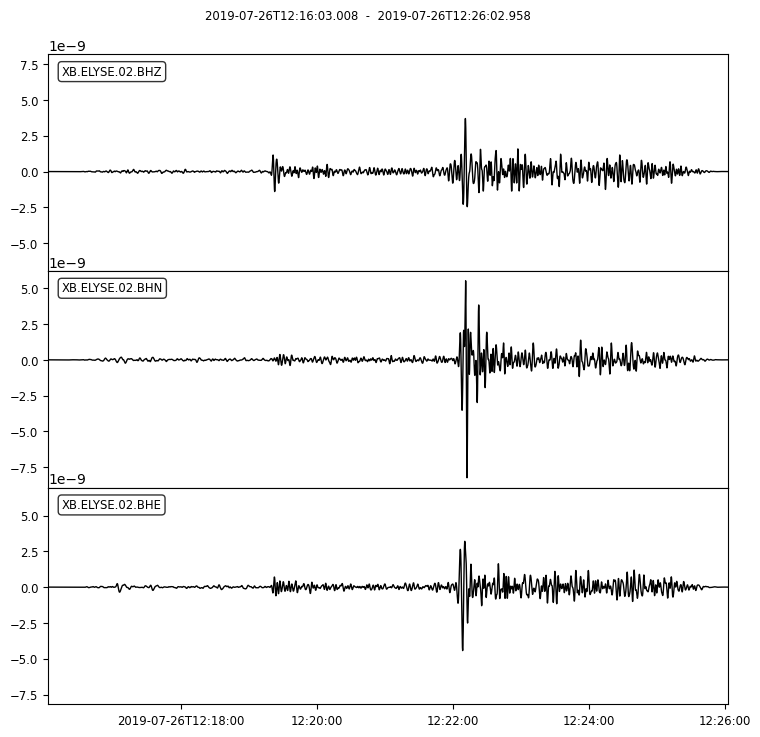

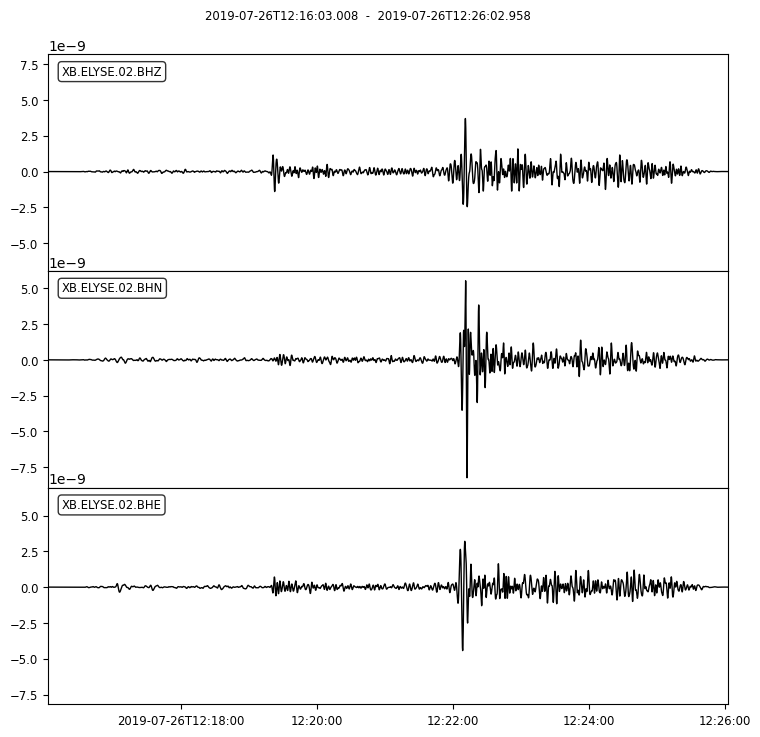

In [34]:
st_zne.plot()

###  <font color='red'>Question 3 </font>

In the plot above, you should see two distinct arrivals corresponding to the P-wave and S-wave. The P-wave is most prominent on BHZ, but is also present on BHE and BHN. The S-wave is the largest signal and is clear on all channels. The difference between the times (i.e., S - P) is related to the epicentral distance.

**1)From your plot above, calculate the S - P time of S0235b. The travel time picks of each phase should be based on the onset of the energy.**


**2) The file `../data/lab_09/tt_table.dat` includes the predicted P and S wave travel times as a function of epicentral distance based on an assumed seismic velocity profile of Mars. They also assume a shallow source. The file contains 3 columns, given as epicentral distance (in degrees), P wave travel time (in seconds), and S wave travel time (in seconds). Use the S - P time you observed above to estimate the epicentral distance of S0235b.**

Note, the reason you need to use S - P time (instead of just P-time or S-time individually), is because you don't know the origin time for certain! The origin time is based on the estimated epicentral distance.

*Hint- The exact S-P time you observed is not likely to be present in the table. You will need to interpolate the predicted S-P times from `tt_table.dat` to find the epicentral distance that your observed S-P time corresponds to. You can do this with numpy.interp*


In [24]:
#Answer Q3 here.
my_p_time_pick = UTCDateTime(2019, 7, 26, 12, 19, 18)
my_s_time_pick = UTCDateTime(2019, 7, 26, 12, 22, 5)
my_sptime = my_s_time_pick - my_p_time_pick
print(my_sptime)


file_path = r"C:\Users\wille\Mars-Seismology-Undergraduate-Research-Project\Spring 2024 Work\tt_table.dat"
with open(file_path, 'r') as file:
    lines = file.readlines()
distances = []
p_times = []
s_times = []
for line in lines:
    if not line.startswith('#'):
        columns = line.split()
        distance = float(columns[0])
        p_time = float(columns[1])    
        s_time = float(columns[2])    
        
        distances.append(distance)
        p_times.append(p_time)
        s_times.append(s_time)
time_differences = [s - p for s, p in zip(s_times, p_times)]
for distance, p_time, s_time, time_diff in zip(distances, p_times, s_times, time_differences):
    print(f"Distance: {distance} deg, S-P Time Difference: {time_diff} s")

167.0
Distance: 0.0 deg, S-P Time Difference: 0.0 s
Distance: 1.0 deg, S-P Time Difference: 13.622000000000002 s
Distance: 2.0 deg, S-P Time Difference: 20.036000000000005 s
Distance: 3.0 deg, S-P Time Difference: 26.247999999999998 s
Distance: 4.0 deg, S-P Time Difference: 33.166000000000004 s
Distance: 5.0 deg, S-P Time Difference: 39.016 s
Distance: 6.0 deg, S-P Time Difference: 44.864 s
Distance: 7.0 deg, S-P Time Difference: 50.711 s
Distance: 8.0 deg, S-P Time Difference: 56.557 s
Distance: 9.0 deg, S-P Time Difference: 62.397999999999996 s
Distance: 10.0 deg, S-P Time Difference: 68.23799999999999 s
Distance: 11.0 deg, S-P Time Difference: 74.074 s
Distance: 12.0 deg, S-P Time Difference: 79.90599999999999 s
Distance: 13.0 deg, S-P Time Difference: 85.734 s
Distance: 14.0 deg, S-P Time Difference: 91.575 s
Distance: 15.0 deg, S-P Time Difference: 97.44399999999999 s
Distance: 16.0 deg, S-P Time Difference: 103.24199999999999 s
Distance: 17.0 deg, S-P Time Difference: 109.042 s
D

In [25]:
import numpy as np
x_values = [27, 28]
y_values = [167.204, 173.037]
desired_y = 170
desired_x = np.interp(desired_y, y_values, x_values)
my_estimated_epicentral_distance = desired_x
print(my_estimated_epicentral_distance, "degrees")

27.479341676667236 degrees


###  <font color='red'>Question 4 </font>

Once the epicentral distance has been determined, the next step is to determine the direction from the station to the marsquake (called the 'back azimuth'). One method for calculating the back azimuth is to try different rotation angles, and determine which one maximizes the P-wave energy on the radial component. This approach is based on the fact that the P-wave is polarized in the plane that connects the source and receiver. However, there are two possible rotation angles (180-degrees apart) that will maximimize the P-wave energy on the radial component. To resolve this 180-degree ambiguity, we can recognize that the rotation angle that corresponds to the correct back azimuth will give a positive correlation between the vertical and radial components. Below, a 'psuedocode' for how this algorithm works is provided.

1. Window the P-wave arrival of the stream.

2. Make a vector of possible rotation angles ranging from from 0 to 360. 

3. Loop over the angles, and apply a rotation from the north (N) and east (E) coordinates to radial (R) and transverse (T) using the proposed angle as the back azimuth (see https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.rotate.html)

4. For each rotation angle, calculate the maximum of the envelope of the radial component, and store this value in a list.

5. For each rotation angle, calculate the correlation coefficient (e.g. with `numpy.correlate`) between the radial and vertical components. Store this value in a list.

6. Plot the two lists (containing the envelope maxima and correlation coefficients) as a function of rotation angle. The rotation angle that corresponds to the correct back azimuth should have a peak in the envelope maxima function, and a positive correlation coefficient.

**Code up the algorithm above to determine the back-azimuth of S0235b. Window the P arrival starting 5 s before the onset and 20 s after the onset (total window length of 25 s)**.

*Hint- use the function Stream.trim() to window the P-wave arrival. This function needs the UTCDateTime of the window start and end time.*

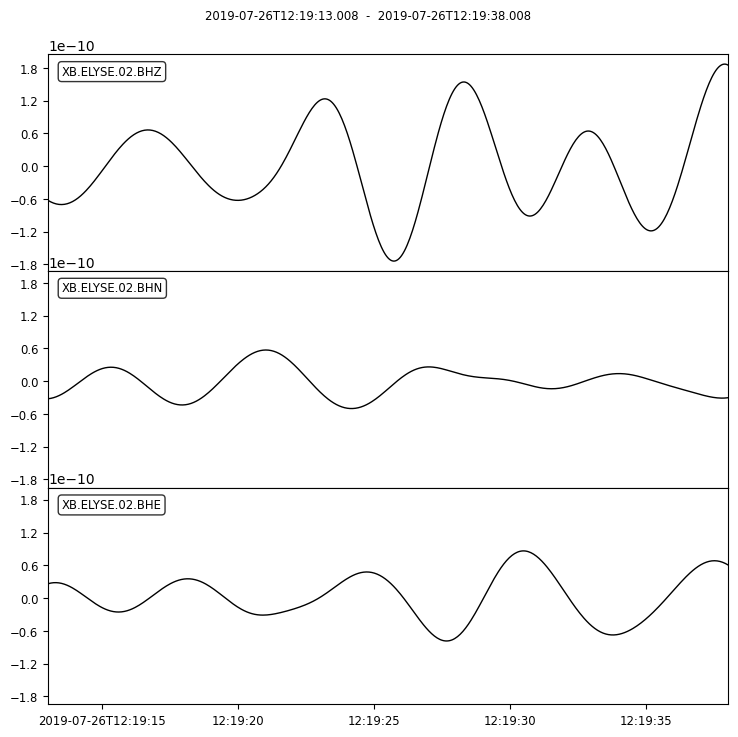

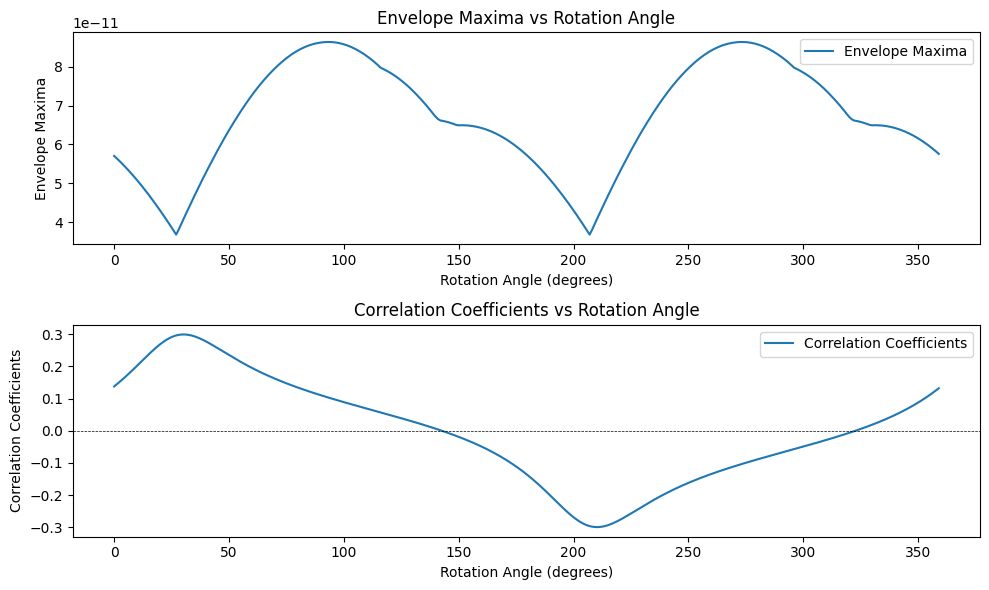

In [26]:
#Answer Q4 here.
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read

stream = st_zne.copy()

# Define window parameters
window_start = my_p_time_pick - 5  # 5 seconds before the onset
window_end = my_p_time_pick + 20  # 20 seconds after the onset

# Window the P-wave arrival
stream.trim(starttime=window_start, endtime=window_end, pad=True, fill_value=0)
stream.plot()

# Define rotation angles
rotation_angles = np.arange(0, 360, 1)

# Initialize lists to store envelope maxima and correlation coefficients
envelope_maxima = []
correlation_coefficients = []

# Loop over rotation angles
for angle in rotation_angles:
    # Rotate the stream
    rotated_stream = stream.copy()
    rotated_stream.rotate(method='NE->RT', back_azimuth=angle)

    # Calculate the envelope of the radial component
    envelope_maxima.append(np.max(np.abs(rotated_stream.select(component='R')[0].data)))

    # Calculate correlation coefficient between radial and vertical components
    radial_component = rotated_stream.select(component='R')[0].data
    vertical_component = rotated_stream.select(component='Z')[0].data
    correlation_coefficients.append(np.corrcoef(radial_component, vertical_component)[0, 1])

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(rotation_angles, envelope_maxima, label='Envelope Maxima')
plt.title('Envelope Maxima vs Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Envelope Maxima')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rotation_angles, correlation_coefficients, label='Correlation Coefficients')
plt.title('Correlation Coefficients vs Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Correlation Coefficients')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Horizontal line at y=0 for reference
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
rotation_angle_for_back_az = 332
print(rotation_angle_for_back_az)
print(my_estimated_epicentral_distance, "degrees")

332
27.479341676667236 degrees


In [28]:
import pyproj

def calc_event_coordinates(dist_deg,back_az):
    '''
    inputs:
    dist_deg- epicentral distance in degrees
    back_az- back azimuth in degrees
    '''

    # Define starting point coordinates
    start_lon, start_lat = 135.62, 4.50  # insight coordinates

    # Define distance (in km)
    mars_radius = 3389.5  # km
    km_per_deg = (2*np.pi*mars_radius)/360.
    distance_km = dist_deg * km_per_deg

    # Calculate endpoint using pyproj
    distance_in_meters = distance_km * 1000

    ev_lon,ev_lat,az = pyproj.Geod(a=mars_radius*1000., b=mars_radius*1000.).fwd(
        start_lon, start_lat, back_az, distance_in_meters)

    return ev_lon,ev_lat

###  <font color='red'>Question 5 </font>

**1. Use the function above `calc_event_coordinates` to calculate the location of S0235b on Mars, based on your estimated distance and back azimuth.**

**2. The MQS reported location of S0235b is lon=160.0, lat=11.49. How does you value compare with this? What are some sources of uncertainty in the analysis that could account for differences? (think about what parameters the distance and back azimuth determinations are sensitive to)**

In [29]:
#Answer Q5 here.
calc_event_coordinates(27.479341676667236, 79)

(162.92111888028873, 9.054882040356468)